## Project 2 - Finance

#### DESCRIPTION

#### Problem Statement

Finance Industry is the biggest consumer of Data Scientists. It faces constant attack by fraudsters, who try to trick the system. Correctly identifying fraudulent transactions is often compared with finding needle in a haystack because of the low event rate. 
It is important that credit card companies are able to recognize fraudulent credit card transactions so that the customers are not charged for items that they did not purchase.
You are required to try various techniques such as supervised models with oversampling, unsupervised anomaly detection, and heuristics to get good accuracy at fraud detection.

#### Dataset Snapshot

The datasets contain transactions made by credit cards in September 2013 by European cardholders. This dataset represents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
It contains only numerical input variables which are the result of a PCA transformation. 
Features V1, V2, ... V28 are the principal components obtained with PCA. 
The only features which have not been transformed with PCA are 'Time' and 'Amount'

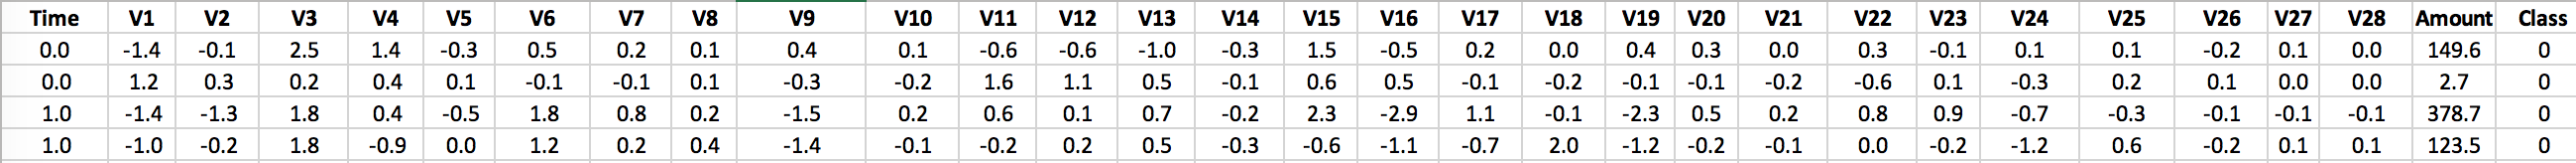

Download the data set from [here](https://www.dropbox.com/s/6z5jxcqaqipxiun/Project%202-Finance-Datasets.zip?dl=0 )

In [93]:
# import required libraries/modules
import pandas as pd
import numpy as np
import seaborn as sns
import base64, io, IPython

from PIL import Image as PILImage

from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score

from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.ioff()

In [94]:
# helper functions for this notebook
def display_image(path):
    img = PILImage.open(path)
    out = io.BytesIO()
    img.save(out, format='PNG')
    enc_str = base64.b64encode(out.getvalue()).decode()
    html = f'<img src="data:image/png;base64,{enc_str}" />'
    return IPython.display.HTML(html)

#### Project Task: Week 1

#### Exploratory Data Analysis (EDA)

1. Perform an EDA on the Dataset.
   1. Check all the latent features and parameters with their mean and standard deviation. Value are close to 0 centered (mean) with unit standard deviation
   2. Find if there is any connection between Time, Amount, and the transaction being fraudulent.
2. Check the class count for each class. It’s a class Imbalance problem.
3. Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM.
   1. Oversampling or undersampling can be used to tackle the class imbalance problem
   2. Oversampling increases the prior probability of imbalanced class and in case of other classifiers, error gets multiplied as the low-proportionate class is mimicked multiple times.
4. Following are the matrices for evaluating the model performance: Precision, Recall, F1-Score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

In [95]:
# V colums
pca_vars = ['V%i' % k for k in range(1,29)]

In [96]:
# load train data
train_df = pd.read_csv('./Financial/train_data.csv')
test_df = pd.read_csv('./Financial/test_data_hidden.csv')

In [97]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    227845 non-null  float64
 1   V1      227845 non-null  float64
 2   V2      227845 non-null  float64
 3   V3      227845 non-null  float64
 4   V4      227845 non-null  float64
 5   V5      227845 non-null  float64
 6   V6      227845 non-null  float64
 7   V7      227845 non-null  float64
 8   V8      227845 non-null  float64
 9   V9      227845 non-null  float64
 10  V10     227845 non-null  float64
 11  V11     227845 non-null  float64
 12  V12     227845 non-null  float64
 13  V13     227845 non-null  float64
 14  V14     227845 non-null  float64
 15  V15     227845 non-null  float64
 16  V16     227845 non-null  float64
 17  V17     227845 non-null  float64
 18  V18     227845 non-null  float64
 19  V19     227845 non-null  float64
 20  V20     227845 non-null  float64
 21  V21     22

#### 1.0 Perform an EDA on the Dataset.


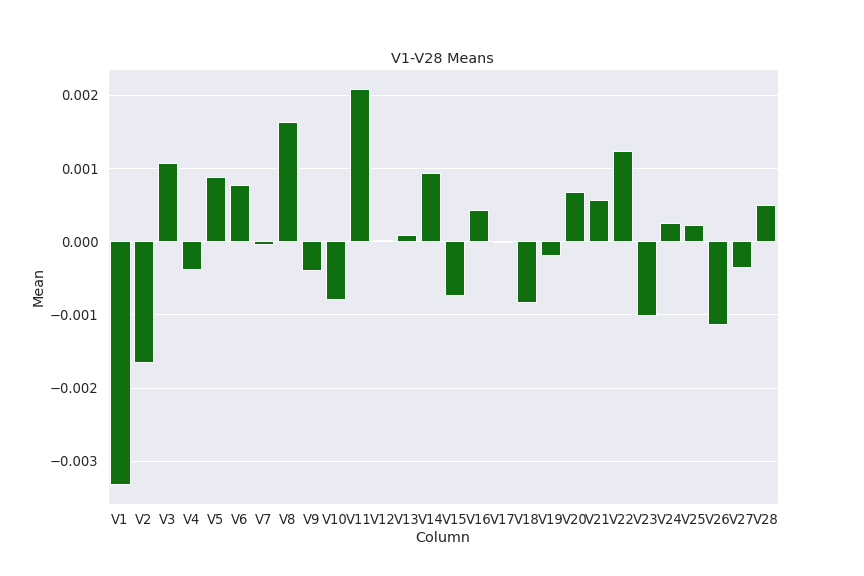

In [98]:
# plot the mean of v columns
plt.figure(figsize=(12,8))
sns.barplot(x=pca_vars, y=train_df[pca_vars].mean(), color='green')
plt.xlabel('Column')
plt.ylabel('Mean')
plt.title('V1-V28 Means')
plt.savefig('./images/eda_v1_v28_means.png')
plt.close()

display_image('./images/eda_v1_v28_means.png')

##### Observation:
> All of V1-V28 have approximately zero mean.


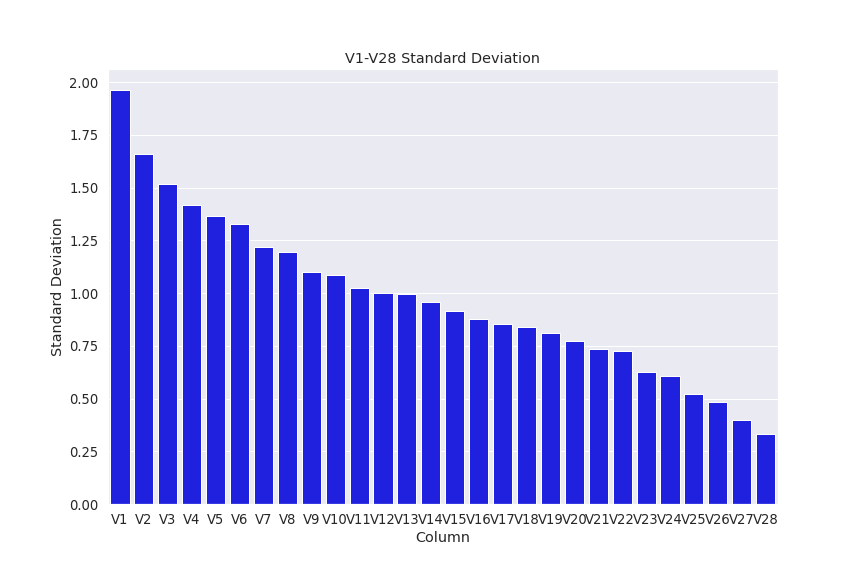

In [99]:
# plot the std of v colums
plt.figure(figsize=(12,8))
sns.barplot(x=pca_vars, y=train_df[pca_vars].std(), color='blue')
plt.xlabel('Column')
plt.ylabel('Standard Deviation')
plt.title('V1-V28 Standard Deviation')
plt.savefig('./images/eda_v1_v28_std.png')
plt.close()

display_image('./images/eda_v1_v28_std.png')

##### Observation:
> The PCA variables have unit variance, but as low as ~0.4 and as high as ~1.9


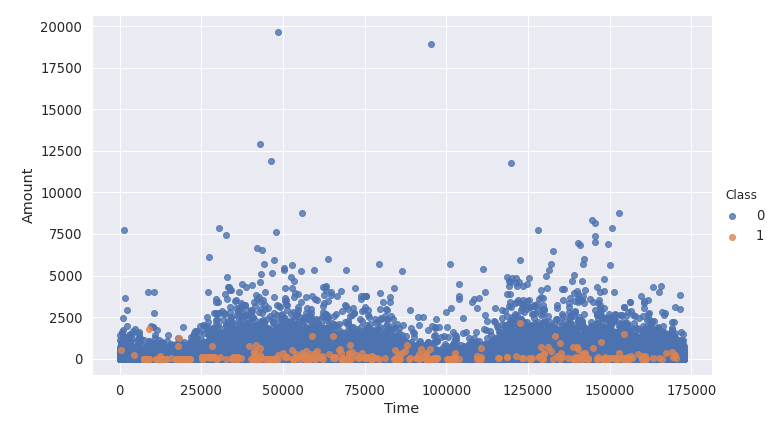

In [100]:
sns.lmplot('Time', 'Amount', train_df, hue='Class', fit_reg=False, height=6, aspect=10/6)
plt.savefig('./images/eda_time_amount_class.png')
plt.close()

display_image('./images/eda_time_amount_class.png')

##### Observation:
> 1. Doesn't seem like the time of transaction really matters.
> 2. Most of the fraud transactions are of low value

#### 2.0 Check the class count for each class. It’s a class Imbalance problem.

No Frauds 99.83 % of the dataset, count( 227451 )
Frauds 0.17 % of the dataset, count( 394 )



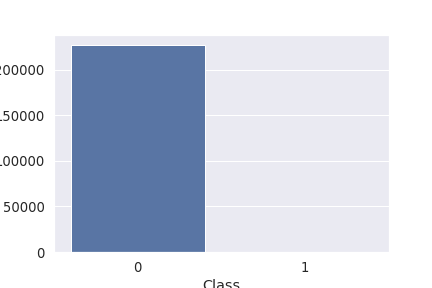

In [101]:
# see the class imbalance
def plot_class_balance(df, name):
    vc = df['Class'].value_counts()
    print('No Frauds', round(vc[0]/len(df) * 100,2), '% of the dataset, count(', vc[0], ')')
    print('Frauds', round(vc[1]/len(df) * 100,2), '% of the dataset, count(', vc[1], ')')
    sns.countplot(x="Class", data=df) 
    plt.savefig(f'./images/{name}.png')
    plt.close()
    
plot_class_balance(train_df, 'class_balance1')
display_image(f'./images/class_balance1.png')

##### Observation:
> Clearly the data is totally unbalanced!!

#### 3.0 Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM

In [102]:
X = train_df.iloc[:, train_df.columns != 'Class']
y = train_df.iloc[:, train_df.columns == 'Class']

In [103]:
def getSamplingF1Score(name, steps):
    # A traditional scikit-learn Pipeline cannot be used; instead, 
    # Pipeline from the imbalanced-learn library can be used
    pl = imPipeline(steps=steps)
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(pl, X, y, scoring='f1', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print(f'{name} F1 Score: {score}')

In [104]:
# trying simple over sampling and under sampling
over = RandomOverSampler()
under = RandomUnderSampler()

getSamplingF1Score('GaussianNB :: Over-Sampling', [
    ('o', over), 
    ('model', GaussianNB())
])
getSamplingF1Score('GaussianNB :: Under-Sampling', [
    ('u', under), 
    ('model', GaussianNB())
])

GaussianNB :: Over-Sampling F1 Score: 0.20239584255803544
GaussianNB :: Under-Sampling F1 Score: 0.17995216852847856


Over-sampling increases the prior probability of imbalanced class and in case of other classifiers, error gets multiplied as the low-proportionate class is mimicked multiple times.

And also we can see Under-Sampling has a very low F1 score.

##### SMOTE Technique (Over-Sampling):
SMOTE stands for Synthetic Minority Over-sampling Technique. Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems".

In [105]:
smote = SMOTE(sampling_strategy='minority')

getSamplingF1Score('GaussianNB :: SMOTE-Sampling', [
    ('s', smote), 
    ('model', GaussianNB())
])

GaussianNB :: SMOTE-Sampling F1 Score: 0.2550324160883535


No Frauds 50.0 % of the dataset, count( 227451 )
Frauds 50.0 % of the dataset, count( 227451 )



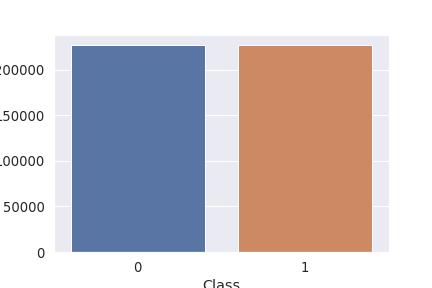

In [106]:
# finally smote the data
X_train_new, y_train_new = smote.fit_sample(X, y)
new_df = X_train_new.copy()
new_df['Class'] = y_train_new

plot_class_balance(new_df, 'class_balance2')
display_image(f'./images/class_balance2.png')

In [107]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454902 entries, 0 to 454901
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    454902 non-null  float64
 1   V1      454902 non-null  float64
 2   V2      454902 non-null  float64
 3   V3      454902 non-null  float64
 4   V4      454902 non-null  float64
 5   V5      454902 non-null  float64
 6   V6      454902 non-null  float64
 7   V7      454902 non-null  float64
 8   V8      454902 non-null  float64
 9   V9      454902 non-null  float64
 10  V10     454902 non-null  float64
 11  V11     454902 non-null  float64
 12  V12     454902 non-null  float64
 13  V13     454902 non-null  float64
 14  V14     454902 non-null  float64
 15  V15     454902 non-null  float64
 16  V16     454902 non-null  float64
 17  V17     454902 non-null  float64
 18  V18     454902 non-null  float64
 19  V19     454902 non-null  float64
 20  V20     454902 non-null  float64
 21  V21     45

#### 4.0 Following are the matrices for evaluating the model performance: Precision, Recall, F1-Score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

In [108]:
# since Time realy does not matter, lets drop the column now
new_df.drop(['Time'], inplace=True, axis=1)
test_df.drop(['Time'], inplace=True, axis=1)

# Amount is not scaled, so lets scale that colums
new_df['Amount'] = StandardScaler().fit_transform(new_df['Amount'].values.reshape(-1, 1))
test_df['Amount'] = StandardScaler().fit_transform(test_df['Amount'].values.reshape(-1, 1))

In [199]:
def plot_cf(y_test, y_pred, name):
    cm_nn=confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
    plt.xlabel("Predicted Label", size = 18)
    plt.ylabel("True Label", size = 18)
    plt.title(f"{name} - Confusion Matrix", size = 20)
    plt.savefig(f'./images/{name}.png')
    plt.close()

def print_f1(y_test, y_pred):
    score = f1_score(y_test, y_pred)
    print(f'F1 Score: {score}')
    
def print_precision(y_test, y_pred):
    score = precision_score(y_test, y_pred)
    print(f'Precision Score: {score}')
    
def print_recall(y_test, y_pred):
    score = recall_score(y_test, y_pred)
    print(f'Recall Score: {score}')

def print_cf_f1(cls, X_test, y_test):
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(cls, X_test, y_test, scoring='f1', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print(f'Cross Validation F1 Score: {score}')

In [110]:
X_train = new_df.iloc[:, new_df.columns != 'Class']
y_train = new_df.iloc[:, new_df.columns == 'Class']

X_test = test_df.iloc[:, test_df.columns != 'Class']
y_test = test_df.iloc[:, test_df.columns == 'Class']

In [196]:
# F1-Score for Naïve Bayes (GaussianNB)
cls_nb = GaussianNB()
cls_nb.fit(X_train, y_train)

y_pred = cls_nb.predict(X_test)
plot_cf(y_test, y_pred, 'GaussianNB')

print_f1(y_test, y_pred)
print_cf_f1(cls_nb, X_test, y_test)

F1 Score: 0.10645375914836991
Cross Validation F1 Score: 0.120777357956075



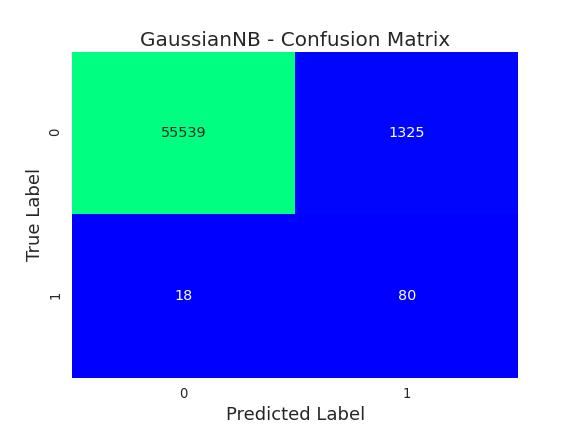

In [112]:
display_image('./images/GaussianNB.png')

In [113]:
# F1-Score for Logistic Regression (LogisticRegression)
cls_lr = LogisticRegression()
cls_lr.fit(X_train, y_train)

y_pred = cls_lr.predict(X_test)
plot_cf(y_test, y_pred, 'LogisticRegression')

print_f1(y_test, y_pred)
print_cf_f1(cls_lr, X_test, y_test)

F1 Score: 0.20648259303721486
Cross Validation F1 Score: 0.6652847805788982



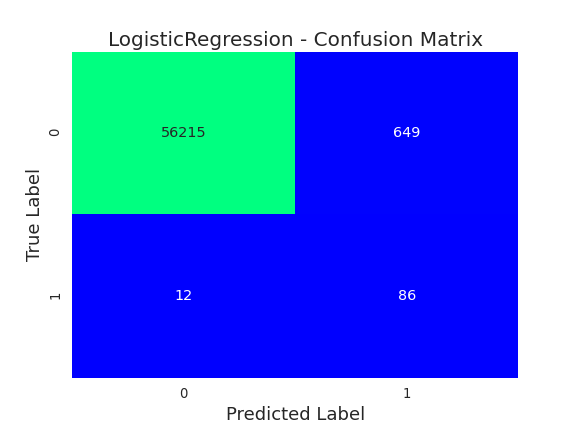

In [114]:
display_image('./images/LogisticRegression.png')

#### Project Task: Week 2

Modeling Techniques:

Try out models like Naive Bayes, Logistic Regression or SVM. Find out which one performs the best
Use different Tree-based classifiers like Random Forest and XGBoost. 
  1. Remember Tree-based classifiers work on two ideologies: Bagging or Boosting
  2. Tree-based classifiers have fine-tuning parameters which takes care of the imbalanced class. Random-Forest and XGBboost.

Compare the results of 1 with 2 and check if there is any incremental gain.

In [23]:
# F1-Score for RandomForestClassifier (RandomForestClassifier)
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier())
])
param_grid_rf = {
    'model__n_estimators': [10, 50, 150],
    'model__max_depth': [5, 25, None],
    'model__min_samples_leaf': [2, 4, 6],
    'model__min_samples_split': [5, 7, 10]
}

grid_rf = GridSearchCV(
    estimator=pipeline_rf, 
    param_grid=param_grid_rf, 
    scoring='f1', 
    n_jobs=-1, 
    pre_dispatch='2*n_jobs', 
    cv=5, 
    verbose=1, 
    return_train_score=False
)

grid_rf.fit(X_train, y_train)

y_pred = grid_rf.best_estimator_.predict(X_test)

plot_cf(y_test, y_pred, 'RandomForestClassifier')

print_f1(y_test, y_pred)
print_cf_f1(grid_rf.best_estimator_, X_test, y_test)

print("\nBest Param", grid_rf.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 89.3min finished


F1 Score: 0.837696335078534
Cross Validation F1 Score: 0.7523718610251118

Best Param {'model__max_depth': 25, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 150}



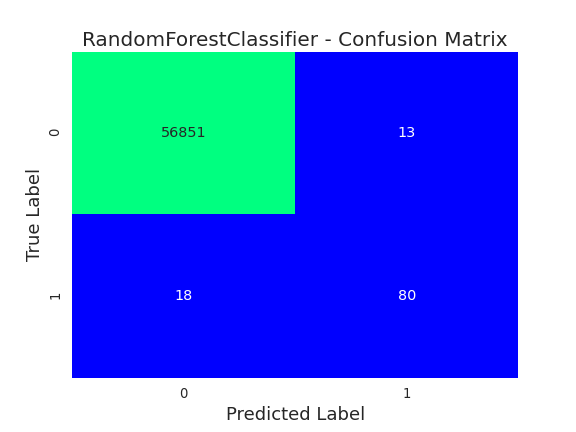

In [24]:
display_image('./images/RandomForestClassifier.png')

In [24]:
## F1-Score for XGBClassifier (XGBClassifier)
pipeline_xgb = Pipeline([
    ('model', XGBClassifier(objective='binary:logistic'))
])
param_grid_xgb = {
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__n_estimators': [50, 100, 200],
    'model__subsample': [0.3, 0.5, 0.9],
    'model__max_depth': [3, 6, 9]
}

grid_xgb = GridSearchCV(
    estimator=pipeline_xgb, 
    param_grid=param_grid_xgb, 
    scoring='f1', 
    n_jobs=-1, 
    pre_dispatch='2*n_jobs', 
    cv=5, 
    verbose=1, 
    return_train_score=False
)
grid_xgb.fit(X_train, y_train)

y_pred = grid_xgb.best_estimator_.predict(X_test)

plot_cf(y_test, y_pred, 'XGBClassifier')

print_f1(y_test, y_pred)
print_cf_f1(grid_xgb.best_estimator_, X_test, y_test)

print("\nBest Param", grid_xgb.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 50.6min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 118.2min finished


F1 Score: 0.8102564102564104
Cross Validation F1 Score: 0.8049406604747162

Best Param {'model__learning_rate': 0.5, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 0.9}



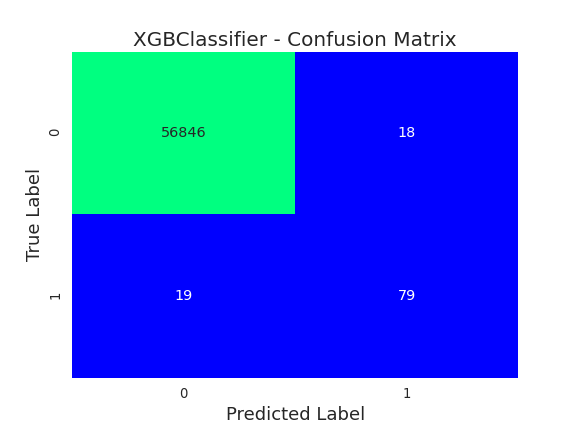

In [197]:
display_image(f'./images/XGBClassifier.png')

##### Observation:
> XGBClassifier we have highest cross validation f1 score

#### Project Task: Week 3

Applying ANN:

1. Use ANN (Artificial Neural Network) to identify fradulent and non-fradulent.
   1. Fine-tune number of layers
   2. Number of Neurons in each layers
   3. Experiment in batch-size
   4. Experiment with number of epochs. Check the observations in loss and accuracy
   5. Play with different Learning Rate variants of Gradient Descent like Adam, SGD, RMS-prop
   6. Find out which activation performs best for this use case and why?
   7. Check Confusion Matrix, Precision, Recall and F1-Score
2. Try out Dropout for ANN. How is it performed? Compare model performance with the traditional ML based prediction models from above. 
3. Find the best setting of neural net that can be best classified as fraudulent and non-fraudulent transactions. Use techniques like Grid Search, Cross-Validation and Random search.

Anomaly Detection:

4. Implement anomaly detection algorithms.
   1. Assume that the data is coming from a single or a combination of multivariate Gaussian
   2. Formalize a scoring criterion, which gives a scoring probability for the given data point whether it belongs to the multivariate Gaussian or Normal Distribution fitted in 1.

In [228]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers

In [148]:
print(tf.__version__)

2.2.0


In [215]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [216]:
INPUT_DIM = X_train.shape[1]

In [241]:
def generate_model(optimizer='Adam', 
                   kernel_initializer='glorot_uniform', 
                   activation='relu',
                   dropout_rate=0.5,
                   learning_rate=0.001, 
                   momentum=0.8):
    _model = Sequential()
    _model.add(Dense(32,input_dim = INPUT_DIM, activation = activation))

    _model.add(Dense(64, activation = activation, kernel_initializer=kernel_initializer))
    _model.add(BatchNormalization())
    _model.add(Dropout(dropout_rate))

    _model.add(Dense(128, activation = activation, kernel_initializer=kernel_initializer))
    _model.add(BatchNormalization())
    _model.add(Dropout(dropout_rate))
    
    _model.add(Dense(16, activation = activation, kernel_initializer=kernel_initializer))
    _model.add(Dropout(dropout_rate))

    _model.add(Dense(1, activation = 'sigmoid'))
    
    if(optimizer=='Adam'):
        optimizer = Adam(learning_rate=learning_rate)
    
    if(optimizer=='SGD'):
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
                   
    if(optimizer=='RMSprop'):
        optimizer = RMSprop(learning_rate=learning_rate)
        
    _model.compile(optimizer = optimizer, loss = 'binary_crossentropy')
    
    return _model

In [234]:
model_sgd = generate_model(optimizer='SGD')

history_sgd = model_sgd.fit(X_train, y_train,
                    epochs=50,
                    batch_size=1000,
                    validation_split=0.4,
                    verbose=0).history

In [235]:
model_adam = generate_model(optimizer='Adam')

history_adam = model_adam.fit(X_train, y_train,
                    epochs=50,
                    batch_size=1000,
                    validation_split=0.4,
                    verbose=0).history


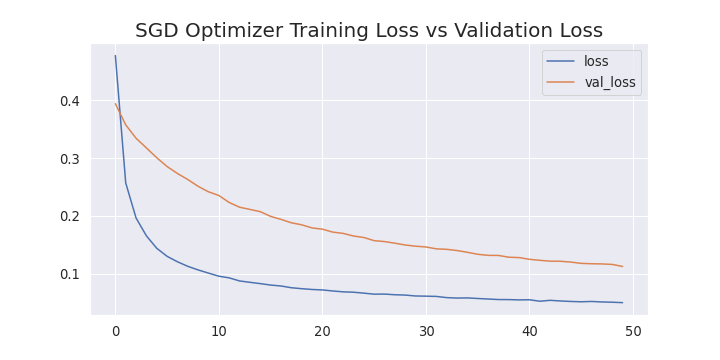

In [236]:
evaluation_metrics=pd.DataFrame(history_sgd)
evaluation_metrics.plot(figsize=(10,5))
plt.title("SGD Optimizer Training Loss vs Validation Loss", size = 20)
plt.savefig('./images/sgd.png')
plt.close()

display_image('./images/sgd.png')


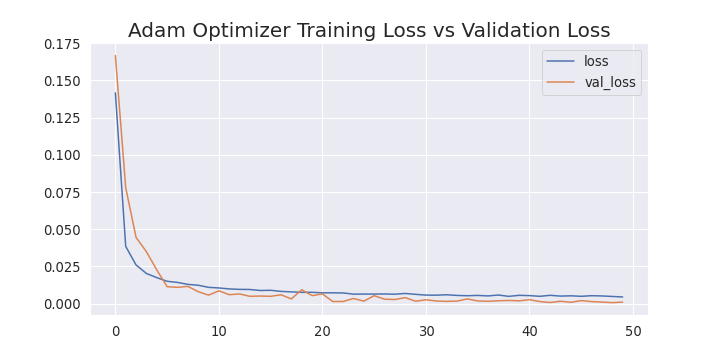

In [237]:
evaluation_metrics=pd.DataFrame(history_adam)
evaluation_metrics.plot(figsize=(10,5))
plt.title("Adam Optimizer Training Loss vs Validation Loss", size = 20)
plt.savefig('./images/adam.png')
plt.close()

display_image('./images/adam.png')

In [238]:
y_pred = model_adam.predict_classes(X_test)

In [239]:
print_f1(y_test, y_pred)
print_precision(y_test, y_pred)
print_recall(y_test, y_pred)

F1 Score: 0.6968325791855203
Precision Score: 0.6260162601626016
Recall Score: 0.7857142857142857



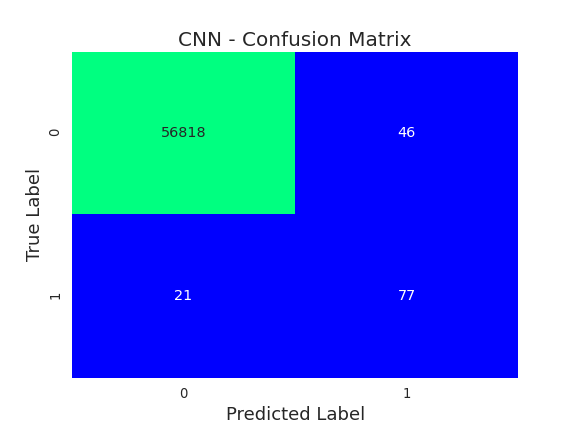

In [240]:
plot_cf(y_test, y_pred, 'CNN')
display_image('./images/CNN.png')

##### Observation:
> If we compare this with the XGBoost or RandomForest model, the little problem here is that, it is doing better prediction for the majority class, which is 0 or "No Fraud" cases, but for minority class, which is 1 or "Fraud" cases, it is performing a little less. There are more number of legitimate transactions that is predicted as a fraud. But I guess with a little more hyperparamters tuning, the model will be able to perform better than the XGBoost or RandomForest even for minority class.

In [ ]:
model_ann = KerasClassifier(build_fn=generate_model)

param_grid_ann = dict(epochs=[30], 
                      batch_size=[1000], 
                      optimizer=['Adam', 'SGD', 'RMSprop'], 
                      kernel_initializer=['glorot_uniform', 'uniform'], 
                      activation=['relu', 'tanh'], 
                      learning_rate=[0.0001, 0.001], 
                      momentum=[0.4, 0.8],
                      dropout_rate=[0.2, 0.5])

grid_ann = GridSearchCV(
    estimator=model_ann, 
    param_grid=param_grid_ann, 
    scoring='f1', 
    n_jobs=1, 
    pre_dispatch='2*n_jobs', 
    cv=5, 
    verbose=3, 
    return_train_score=False
)
grid_ann.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] activation=relu, batch_size=1000, dropout_rate=0.2, epochs=30, kernel_initializer=glorot_uniform, learning_rate=0.0001, momentum=0.4, optimizer=Adam 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2404
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0829
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0542
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0409
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0327
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0266
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0223
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0193
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0165
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0145
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0128
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0112
Epoch 13/30
364/364 [====

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.5s remaining:    0.0s


Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3921
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1147
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0699
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0507
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0394
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0319
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0265
Epoch 8/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0227
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0198
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0172
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0150
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0134
Epoch 13/30
364/364 [====

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.0s remaining:    0.0s


Epoch 1/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2959
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0954
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0662
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0514
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0412
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0346
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0292
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0255
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0225
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0200
Epoch 11/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0176
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0158
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.6263
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5568
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5135
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4805
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4523
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4290
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4099
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3919
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3761
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3622
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3482
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3361
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 2ms/step - loss: 0.8811
Epoch 2/30
364/364 [==============================] - 1s 2ms/step - loss: 0.6546
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.5350
Epoch 4/30
364/364 [==============================] - 1s 2ms/step - loss: 0.4616
Epoch 5/30
364/364 [==============================] - 1s 2ms/step - loss: 0.4079
Epoch 6/30
364/364 [==============================] - 1s 2ms/step - loss: 0.3664
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3345
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3094
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2889
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2731
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2592
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2468
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2386
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0652
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0423
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0317
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0250
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0203
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0174
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0157
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0132
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0122
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0110
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0099
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2392
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0775
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0546
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0429
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0357
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0299
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0259
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0227
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0205
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0184
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0164
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0154
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2608
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0984
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0640
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0472
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0372
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0304
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0259
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0222
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0192
Epoch 10/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0174
Epoch 11/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0156
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 2ms/step - loss: 0.7087
Epoch 2/30
364/364 [==============================] - 1s 2ms/step - loss: 0.4903
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.3973
Epoch 4/30
364/364 [==============================] - 1s 2ms/step - loss: 0.3388
Epoch 5/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2972
Epoch 6/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2648
Epoch 7/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2405
Epoch 8/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2199
Epoch 9/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2045
Epoch 10/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1915
Epoch 11/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1806
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1712
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 2ms/step - loss: 0.9062
Epoch 2/30
364/364 [==============================] - 1s 2ms/step - loss: 0.5013
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.3639
Epoch 4/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2903
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2466
Epoch 6/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2178
Epoch 7/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1974
Epoch 8/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1828
Epoch 9/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1704
Epoch 10/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1616
Epoch 11/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1543
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1481
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2549
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0789
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0524
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0383
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0300
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0247
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0177
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0161
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0138
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0127
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0116
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2070
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0611
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0442
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0346
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0284
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0245
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0215
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0183
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0170
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0156
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0141
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0130
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0628
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0143
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0086
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5211
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2977
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2176
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1732
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1462
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1295
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1173
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1082
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1005
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0945
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0896
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0856
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4628
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2142
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1606
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1362
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1216
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1115
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1036
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0973
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0928
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0882
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0845
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0821
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0458
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0092
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0062
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0032
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0562
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0144
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0095
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0074
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0060
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0620
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0158
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0094
Epoch 4/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0057
Epoch 6/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0048
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0032
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3061
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1482
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1115
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0930
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0808
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0714
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0651
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0590
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0551
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0520
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0485
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0452
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3242
Epoch 2/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1419
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1101
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0937
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0827
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0743
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0682
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0630
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0588
Epoch 10/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0549
Epoch 11/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0520
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0497
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0571
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0128
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0081
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0061
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0054
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0566
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0123
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0078
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0062
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1768
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0481
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0292
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0208
Epoch 5/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0160
Epoch 6/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0110
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0094
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0084
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0076
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0072
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0062
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 2ms/step - loss: 0.6037
Epoch 2/30
364/364 [==============================] - 1s 2ms/step - loss: 0.5092
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4500
Epoch 4/30
364/364 [==============================] - 1s 2ms/step - loss: 0.4051
Epoch 5/30
364/364 [==============================] - 1s 2ms/step - loss: 0.3689
Epoch 6/30
364/364 [==============================] - 1s 2ms/step - loss: 0.3388
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3133
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2922
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2729
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2557
Epoch 11/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2406
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2272
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.6289
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5599
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5074
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4612
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4190
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3810
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3471
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3171
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2916
Epoch 10/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2699
Epoch 11/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2509
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2348
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1833
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0359
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0218
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0158
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0126
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0104
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0089
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0077
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0070
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0060
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1653
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0439
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0288
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0170
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0140
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0122
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0109
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0100
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0086
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0080
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1653
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0447
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0268
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0188
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0145
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0118
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0099
Epoch 8/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0086
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0070
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0057
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4822
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3398
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2678
Epoch 4/30
364/364 [==============================] - 1s 2ms/step - loss: 0.2201
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1872
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1630
Epoch 7/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1446
Epoch 8/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1301
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1194
Epoch 10/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1102
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1031
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0970
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5508
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3663
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2752
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2204
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1854
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1613
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1446
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1317
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1223
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1147
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1084
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1034
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1578
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0319
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0197
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0141
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0109
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0092
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0077
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0066
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0061
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1574
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0434
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0287
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0209
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0168
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0135
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0120
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0102
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0092
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0085
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0077
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0391
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0098
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0071
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0060
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0032
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4347
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2341
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1590
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1259
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1083
Epoch 6/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0960
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0871
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0803
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0747
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0702
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0660
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0625
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3765
Epoch 2/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1689
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.1250
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1050
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0931
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0846
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0784
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0733
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0697
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0665
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0636
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0609
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0336
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0092
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0405
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0108
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0061
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0427
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0096
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0067
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0058
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.3087
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1189
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0833
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0662
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0544
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0461
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0397
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0349
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0313
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0282
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0250
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0231
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2111
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0843
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0651
Epoch 4/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0554
Epoch 5/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0485
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0430
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0395
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0354
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0328
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0303
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0279
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0264
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0387
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0070
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0056
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0365
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0112
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0081
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0054
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5404
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.2364
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1649
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1284
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1067
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0914
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0795
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0712
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0639
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0588
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0542
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.0504
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.8596
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.7855
Epoch 3/30
364/364 [==============================] - 1s 2ms/step - loss: 0.7320
Epoch 4/30
364/364 [==============================] - 1s 2ms/step - loss: 0.6866
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.6468
Epoch 6/30
364/364 [==============================] - 1s 2ms/step - loss: 0.6189
Epoch 7/30
364/364 [==============================] - 1s 2ms/step - loss: 0.5934
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5706
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5538
Epoch 10/30
364/364 [==============================] - 1s 2ms/step - loss: 0.5346
Epoch 11/30
364/364 [==============================] - 1s 2ms/step - loss: 0.5213
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.5071
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 1.0932
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.9376
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.8343
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.7570
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.6994
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.6538
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.6144
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5847
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5597
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.5355
Epoch 11/30
364/364 [==============================] - 1s 2ms/step - loss: 0.5153
Epoch 12/30
364/364 [==============================] - 1s 2ms/step - loss: 0.4975
Epoch 13/30
364/364 [====

Epoch 1/30
364/364 [==============================] - 1s 3ms/step - loss: 0.4908
Epoch 2/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1641
Epoch 3/30
364/364 [==============================] - 1s 3ms/step - loss: 0.1026
Epoch 4/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0792
Epoch 5/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0657
Epoch 6/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0572
Epoch 7/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0502
Epoch 8/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0441
Epoch 9/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0404
Epoch 10/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0371
Epoch 11/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0341
Epoch 12/30
364/364 [==============================] - 1s 3ms/step - loss: 0.0312
Epoch 13/30
364/364 [====

In [ ]:
y_pred = grid_ann.best_estimator_.predict(X_test_d)
print("\nBest Param", grid_ann.best_params_)

In [ ]:
plot_cf(y_test, y_pred, 'CNNBest')
display_image('./images/CNNBest.png')

In [ ]:
print_f1(y_test, y_pred)
print_precision(y_test, y_pred)
print_recall(y_test, y_pred)

#### Anomaly Detection:

Implement anomaly detection algorithms.
1. Assume that the data is coming from a single or a combination of multivariate Gaussian
2. Formalize a scoring criterion, which gives a scoring probability for the given data point whether it belongs to the multivariate Gaussian or Normal Distribution fitted in 1

#### Project Task: Week 4

Inference and Observations:

Visualize the scores for Fraudulent and Non-Fraudulent transactions.
Find out the threshold value for marking or reporting a transaction as fraudulent in your anomaly detection system.
Can this score be used as an engineered feature in the models developed previously? Are there any incremental gains in F1-Score? Why or Why not?
Be as creative as possible in finding other interesting insights.